# **Bibliothéque**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Downloading the Data**

In [ ]:
# Get the latest data
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 19513, done.
remote: Total 19513 (delta 0), reused 0 (delta 0), pack-reused 19513
Receiving objects: 100% (19513/19513), 79.20 MiB | 6.88 MiB/s, done.
Resolving deltas: 100% (10142/10142), done.


# **Loading the Data**

In [ ]:
cases = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19


In [ ]:
deaths = pd.read_csv('/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [ ]:
pd.read_csv('/content/drive/My Drive/covid_pred/zindi/train.csv')

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20
...,...,...,...,...,...
15461,Zimbabwe X 3/31/20,1,8,Zimbabwe,3/31/20
15462,Zimbabwe X 4/1/20,1,8,Zimbabwe,4/1/20
15463,Zimbabwe X 4/2/20,1,9,Zimbabwe,4/2/20
15464,Zimbabwe X 4/3/20,1,9,Zimbabwe,4/3/20


# **Adding All Countries**

In [ ]:
# Download a list of countries from the UN
!curl -o EF.xlsx https://untermportal.un.org/unterm/country/downloadfile?targetLanguage=fr

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11199  100 11199    0     0   7470      0  0:00:01  0:00:01 --:--:--  7466


In [ ]:
countries = pd.read_excel('EF.xlsx')[:193]
countries.head(2)

,English short,French short,English formal,French formal
0,Afghanistan,Afghanistan (l'),the Islamic Republic of Afghanistan,la République islamique d'Afghanistan
1,Albania,Albanie (l'),the Republic of Albania,la République d'Albanie


# **data**

In [ ]:
train=pd.read_csv('/content/drive/My Drive/covid_pred/zindi/train.csv')

In [ ]:
reference=pd.read_csv('/content/drive/My Drive/covid_pred/zindi/reference.csv')

# **prépocessing**

In [ ]:
train

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20
...,...,...,...,...,...
15461,Zimbabwe X 3/31/20,1,8,Zimbabwe,3/31/20
15462,Zimbabwe X 4/1/20,1,8,Zimbabwe,4/1/20
15463,Zimbabwe X 4/2/20,1,9,Zimbabwe,4/2/20
15464,Zimbabwe X 4/3/20,1,9,Zimbabwe,4/3/20


In [ ]:
reference

,Territory X Date,target,confirmed
0,Afghanistan X 4/5/20,7,349
1,Afghanistan X 4/6/20,11,367
2,Afghanistan X 4/7/20,14,423
3,Afghanistan X 4/8/20,14,444
4,Afghanistan X 4/9/20,15,484
...,...,...,...
1458,Zimbabwe X 4/7/20,2,11
1459,Zimbabwe X 4/8/20,3,11
1460,Zimbabwe X 4/9/20,3,11
1461,Zimbabwe X 4/10/20,3,13


Text(0.5, 0, 'Date')

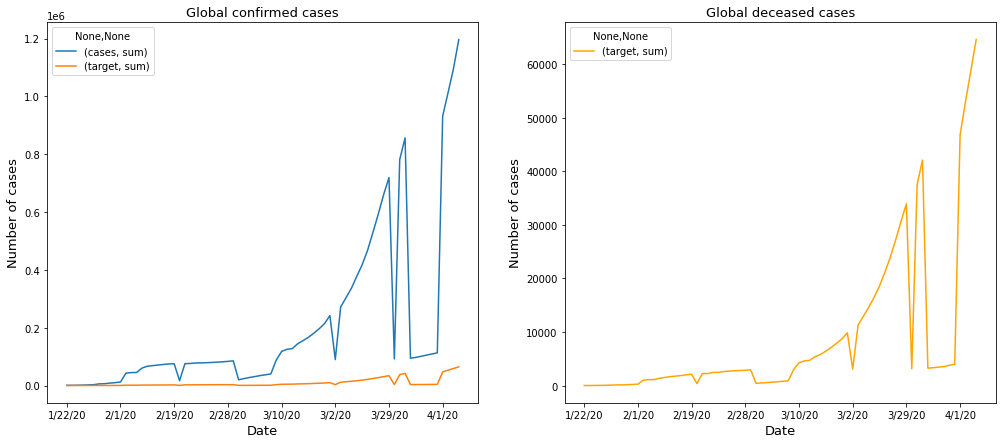

In [ ]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'cases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'target':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])

In [ ]:
train

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22
1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23
2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24
3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25
4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26
...,...,...,...,...,...
15461,Zimbabwe X 3/31/20,1,8,Zimbabwe,2020-03-31
15462,Zimbabwe X 4/1/20,1,8,Zimbabwe,2020-04-01
15463,Zimbabwe X 4/2/20,1,9,Zimbabwe,2020-04-02
15464,Zimbabwe X 4/3/20,1,9,Zimbabwe,2020-04-03


In [ ]:
# Create date columns
le = preprocessing.LabelEncoder()
train['Day_num'] = le.fit_transform(train.Date)
train['Day'] = train['Date'].dt.day
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year

# Fill null values given that we merged train-test datasets
#train['Province/State'].fillna("None", inplace=True)
train['cases'].fillna(0, inplace=True)
train['target'].fillna(0, inplace=True)
# train['Id'].fillna(-1, inplace=True)
# train['ForecastId'].fillna(-1, inplace=True)

display(train)
display(train.loc[train['Date'] == '2020-04-01'])

,Territory X Date,target,cases,Territory,Date,Day_num,Day,Month,Year
0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22,0,22,1,2020
1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23,1,23,1,2020
2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24,2,24,1,2020
3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25,3,25,1,2020
4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26,4,26,1,2020
...,...,...,...,...,...,...,...,...,...
15461,Zimbabwe X 3/31/20,1,8,Zimbabwe,2020-03-31,69,31,3,2020
15462,Zimbabwe X 4/1/20,1,8,Zimbabwe,2020-04-01,70,1,4,2020
15463,Zimbabwe X 4/2/20,1,9,Zimbabwe,2020-04-02,71,2,4,2020
15464,Zimbabwe X 4/3/20,1,9,Zimbabwe,2020-04-03,72,3,4,2020


,Territory X Date,target,cases,Territory,Date,Day_num,Day,Month,Year
70,Afghanistan X 4/1/20,4,237,Afghanistan,2020-04-01,70,1,4,2020
144,Albania X 4/1/20,15,259,Albania,2020-04-01,70,1,4,2020
218,Algeria X 4/1/20,58,847,Algeria,2020-04-01,70,1,4,2020
292,Andorra X 4/1/20,14,390,Andorra,2020-04-01,70,1,4,2020
366,Angola X 4/1/20,2,8,Angola,2020-04-01,70,1,4,2020
...,...,...,...,...,...,...,...,...,...
15166,Venezuela (Bolivarian Republic of) X 4/1/20,3,143,Venezuela (Bolivarian Republic of),2020-04-01,70,1,4,2020
15240,Viet Nam X 4/1/20,0,218,Viet Nam,2020-04-01,70,1,4,2020
15314,Yemen X 4/1/20,0,0,Yemen,2020-04-01,70,1,4,2020
15388,Zambia X 4/1/20,0,36,Zambia,2020-04-01,70,1,4,2020


In [ ]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby('Territory')[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby('Territory')[column].shift(0, fill_value=0) - 
                                df.groupby('Territory')[column].shift(lag, fill_value=0))/df.groupby('Territory')[column].shift(lag, fill_value=0.001)
    return df


ts = time.time()
train = calculate_lag(train.reset_index(), range(1,7), 'cases')
train = calculate_lag(train, range(1,7), 'target')
train = calculate_trend(train, range(1,7), 'cases')
train = calculate_trend(train, range(1,7), 'target')
train.replace([np.inf, -np.inf], 0, inplace=True)
train.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  2.285863161087036


In [ ]:
train[train['Territory']=='Spain'].iloc[40:50]
#[['Id', 'Province/State', 'Country/Region', 'Date',
#        'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
#        'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
#        'Fatalities_3']]

,index,Territory X Date,target,cases,Territory,Date,Day_num,Day,Month,Year,cases_1,cases_2,cases_3,cases_4,cases_5,cases_6,target_1,target_2,target_3,target_4,target_5,target_6,Trend_cases_1,Trend_cases_2,Trend_cases_3,Trend_cases_4,Trend_cases_5,Trend_cases_6,Trend_target_1,Trend_target_2,Trend_target_3,Trend_target_4,Trend_target_5,Trend_target_6
13064,13064,Spain X 3/2/20,0,120,Spain,2020-03-02,40,2,3,2020,84,45,32,15,13,6,0,0,0,0,0,0,0.428571,1.666667,2.750000,7.000000,8.230769,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13065,13065,Spain X 3/3/20,1,165,Spain,2020-03-03,41,3,3,2020,120,84,45,32,15,13,0,0,0,0,0,0,0.375000,0.964286,2.666667,4.156250,10.000000,11.692308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13066,13066,Spain X 3/4/20,2,222,Spain,2020-03-04,42,4,3,2020,165,120,84,45,32,15,1,0,0,0,0,0,0.345455,0.850000,1.642857,3.933333,5.937500,13.800000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
13067,13067,Spain X 3/5/20,3,259,Spain,2020-03-05,43,5,3,2020,222,165,120,84,45,32,2,1,0,0,0,0,0.166667,0.569697,1.158333,2.083333,4.755556,7.093750,0.500000,2.000000,0.000000,0.000000,0.000000,0.0
13068,13068,Spain X 3/6/20,5,400,Spain,2020-03-06,44,6,3,2020,259,222,165,120,84,45,3,2,1,0,0,0,0.544402,0.801802,1.424242,2.333333,3.761905,7.888889,0.666667,1.500000,4.000000,0.000000,0.000000,0.0
13069,13069,Spain X 3/7/20,10,500,Spain,2020-03-07,45,7,3,2020,400,259,222,165,120,84,5,3,2,1,0,0,0.250000,0.930502,1.252252,2.030303,3.166667,4.952381,1.000000,2.333333,4.000000,9.000000,0.000000,0.0
13070,13070,Spain X 3/8/20,17,673,Spain,2020-03-08,46,8,3,2020,500,400,259,222,165,120,10,5,3,2,1,0,0.346000,0.682500,1.598456,2.031532,3.078788,4.608333,0.700000,2.400000,4.666667,7.500000,16.000000,0.0
13071,13071,Spain X 3/9/20,28,1073,Spain,2020-03-09,47,9,3,2020,673,500,400,259,222,165,17,10,5,3,2,1,0.594354,1.146000,1.682500,3.142857,3.833333,5.503030,0.647059,1.800000,4.600000,8.333333,13.000000,27.0
13072,13072,Spain X 3/10/20,35,1695,Spain,2020-03-10,48,10,3,2020,1073,673,500,400,259,222,28,17,10,5,3,2,0.579683,1.518574,2.390000,3.237500,5.544402,6.635135,0.250000,1.058824,2.500000,6.000000,10.666667,16.5
13073,13073,Spain X 3/11/20,54,2277,Spain,2020-03-11,49,11,3,2020,1695,1073,673,500,400,259,35,28,17,10,5,3,0.343363,1.122088,2.383358,3.554000,4.692500,7.791506,0.542857,0.928571,2.176471,4.400000,9.800000,17.0


In [ ]:
# Load countries data file
world_population = pd.read_csv("/content/drive/My Drive/covid_pred/covid19-global-forecasting-week-1/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)



Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61
1,India,1380004385,464,2973190,28,35
2,US,331002651,36,9147420,38,83
3,Indonesia,273523615,151,1811570,30,56
4,Pakistan,220892340,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4992,50,100,19,10
231,Falkland Islands,3480,0,12170,19,66
232,Niue,1626,6,260,19,46
233,Tokelau,1357,136,10,19,0


In [ ]:
# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
train = train.merge(world_population, left_on='Territory', right_on='Country (or dependency)', how='left')
train[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = train[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(train)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
train.drop('Country (or dependency)', inplace=True, axis=1)
train['Territory'] = le.fit_transform(train['Territory'])
number_c = train['Territory']
countries = le.inverse_transform(train['Territory'])
country_dict = dict(zip(countries, number_c)) 
# all_data['Province/State'] = le.fit_transform(all_data['Province/State'])
# number_p = all_data['Province/State']
# province = le.inverse_transform(all_data['Province/State'])
# province_dict = dict(zip(province, number_p)) 
display(train)

Joined dataset


,index,Territory X Date,target,cases,Territory,Date,Day_num,Day,Month,Year,cases_1,cases_2,cases_3,cases_4,cases_5,cases_6,target_1,target_2,target_3,target_4,target_5,target_6,Trend_cases_1,Trend_cases_2,Trend_cases_3,Trend_cases_4,Trend_cases_5,Trend_cases_6,Trend_target_1,Trend_target_2,Trend_target_3,Trend_target_4,Trend_target_5,Trend_target_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22,0,22,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
1,1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23,1,23,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
2,2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24,2,24,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
3,3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25,3,25,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
4,4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26,4,26,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15461,15461,Zimbabwe X 3/31/20,1,8,Zimbabwe,2020-03-31,69,31,3,2020,7,7,7,5,3,3,1,1,1,1,1,1,0.142857,0.142857,0.142857,0.600000,1.666667,1.666667,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
15462,15462,Zimbabwe X 4/1/20,1,8,Zimbabwe,2020-04-01,70,1,4,2020,8,7,7,7,5,3,1,1,1,1,1,1,0.000000,0.142857,0.142857,0.142857,0.600000,1.666667,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
15463,15463,Zimbabwe X 4/2/20,1,9,Zimbabwe,2020-04-02,71,2,4,2020,8,8,7,7,7,5,1,1,1,1,1,1,0.125000,0.125000,0.285714,0.285714,0.285714,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
15464,15464,Zimbabwe X 4/3/20,1,9,Zimbabwe,2020-04-03,72,3,4,2020,9,8,8,7,7,7,1,1,1,1,1,1,0.000000,0.125000,0.125000,0.285714,0.285714,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0


Encoded dataset


,index,Territory X Date,target,cases,Territory,Date,Day_num,Day,Month,Year,cases_1,cases_2,cases_3,cases_4,cases_5,cases_6,target_1,target_2,target_3,target_4,target_5,target_6,Trend_cases_1,Trend_cases_2,Trend_cases_3,Trend_cases_4,Trend_cases_5,Trend_cases_6,Trend_target_1,Trend_target_2,Trend_target_3,Trend_target_4,Trend_target_5,Trend_target_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,Afghanistan X 1/22/20,0,0,0,2020-01-22,0,22,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
1,1,Afghanistan X 1/23/20,0,0,0,2020-01-23,1,23,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
2,2,Afghanistan X 1/24/20,0,0,0,2020-01-24,2,24,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
3,3,Afghanistan X 1/25/20,0,0,0,2020-01-25,3,25,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
4,4,Afghanistan X 1/26/20,0,0,0,2020-01-26,4,26,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15461,15461,Zimbabwe X 3/31/20,1,8,208,2020-03-31,69,31,3,2020,7,7,7,5,3,3,1,1,1,1,1,1,0.142857,0.142857,0.142857,0.600000,1.666667,1.666667,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
15462,15462,Zimbabwe X 4/1/20,1,8,208,2020-04-01,70,1,4,2020,8,7,7,7,5,3,1,1,1,1,1,1,0.000000,0.142857,0.142857,0.142857,0.600000,1.666667,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
15463,15463,Zimbabwe X 4/2/20,1,9,208,2020-04-02,71,2,4,2020,8,8,7,7,7,5,1,1,1,1,1,1,0.125000,0.125000,0.285714,0.285714,0.285714,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
15464,15464,Zimbabwe X 4/3/20,1,9,208,2020-04-03,72,3,4,2020,9,8,8,7,7,7,1,1,1,1,1,1,0.000000,0.125000,0.125000,0.285714,0.285714,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0


# **ARIMA**

In [ ]:
!pip install pyramid.arima
from pyramid.arima import auto_arima

     |████████████████████████████████| 604kB 14.6MB/s 


In [ ]:
# Define a general function to run ARIMA regression
def arima_cp(data, country_name, target, train_lim, test_lim):
    
    #Select data for the Country/Region, splitting train/test days
    data_cp = data.loc[(data['Territory']==country_dict[country_name])]
    data_cp_train = data_cp.loc[(data_cp['Day_num'])<=train_lim, target].astype(np.int32)
    data_cp_test = data_cp.loc[(data_cp['Day_num'])>test_lim, target].astype(np.int32)

    # Set the range of parameters to use
    stepwise_model = auto_arima(data_cp[target], start_p=1, start_q=1, max_p=30, max_q=30, 
                                start_P=0, seasonal=False, d=2, trace=False, error_action='ignore', stepwise=True)

    # Train and predict
    stepwise_model.fit(data_cp_train, start_ar_lags=2*max(30, 30))
    forecast = stepwise_model.predict(n_periods=test_lim-train_lim)
    return forecast

In [ ]:
country_name = 'Spain'

train_lim = 67
valid_lim = 73 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim

In [ ]:
forecast = arima_cp(train, country_name, 'target', train_lim, test_lim)

In [ ]:
forecast

array([ 7453.7037735 ,  8316.2438278 ,  8967.06854216,  9621.39880802,
       10325.39140422, 11004.4604012 , 11537.35656754, 12310.58071787,
       12906.28752388, 13543.19319655, 14263.55584589, 14982.86196602,
       15582.19522414, 16435.09614841, 17118.39858625, 17848.70007665,
       18663.04008061, 19469.29343426, 20155.17114836, 21086.76274586,
       21841.58458895, 22639.78709243, 23517.99237451, 24380.6084508 ,
       25124.82953229, 26111.13907484, 26918.79733112, 27771.75685407,
       28705.75522148, 29621.19215153, 30423.75956999, 31467.30174023,
       32331.96109972, 33244.67775403, 34239.5001606 , 35212.48976067,
       36077.43925128, 37181.33279686, 38105.2314978 , 39079.12243386,
       40135.34686673, 41165.94332653, 42092.89296168, 43256.42813702,
       44238.75000086])

In [ ]:
len(forecast)

45

In [ ]:
dates_overlap = [ '2020-04-06', '2020-04-07', '2020-04-08','2020-04-09','2020-04-10','2020-04-11','2020-04-12','2020-04-13','2020-04-14','2020-04-15']


In [ ]:
train

,index,Territory X Date,target,cases,Territory,Date,Day_num,Day,Month,Year,cases_1,cases_2,cases_3,cases_4,cases_5,cases_6,target_1,target_2,target_3,target_4,target_5,target_6,Trend_cases_1,Trend_cases_2,Trend_cases_3,Trend_cases_4,Trend_cases_5,Trend_cases_6,Trend_target_1,Trend_target_2,Trend_target_3,Trend_target_4,Trend_target_5,Trend_target_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,Afghanistan X 1/22/20,0,0,0,2020-01-22,0,22,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
1,1,Afghanistan X 1/23/20,0,0,0,2020-01-23,1,23,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
2,2,Afghanistan X 1/24/20,0,0,0,2020-01-24,2,24,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
3,3,Afghanistan X 1/25/20,0,0,0,2020-01-25,3,25,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
4,4,Afghanistan X 1/26/20,0,0,0,2020-01-26,4,26,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15461,15461,Zimbabwe X 3/31/20,1,8,208,2020-03-31,69,31,3,2020,7,7,7,5,3,3,1,1,1,1,1,1,0.142857,0.142857,0.142857,0.600000,1.666667,1.666667,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
15462,15462,Zimbabwe X 4/1/20,1,8,208,2020-04-01,70,1,4,2020,8,7,7,7,5,3,1,1,1,1,1,1,0.000000,0.142857,0.142857,0.142857,0.600000,1.666667,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
15463,15463,Zimbabwe X 4/2/20,1,9,208,2020-04-02,71,2,4,2020,8,8,7,7,7,5,1,1,1,1,1,1,0.125000,0.125000,0.285714,0.285714,0.285714,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
15464,15464,Zimbabwe X 4/3/20,1,9,208,2020-04-03,72,3,4,2020,9,8,8,7,7,7,1,1,1,1,1,1,0.000000,0.125000,0.125000,0.285714,0.285714,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0


In [ ]:
df_train = train.loc[(train['Territory']==country_name) , target]

In [ ]:
df_train

In [ ]:
def plot_arima_country(data, train, forecast, dates_overlap, country_name, valid_num, target):
  df_train = train.loc[(train['Territory']==country_name) , target]
  df_fcst = np.append(df_train[:-valid_num], forecast[:valid_num])
  dates = list(range(0,len(df_train)))
    
    # Plot results
  fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
  ax1.plot(dates, df_fcst)
  ax1.plot(dates, df_train)
  ax1.axvline(len(df_train)-valid_num-1, linewidth=2, ls = ':', color='grey', alpha=0.5)
  ax1.set_title("Actual ConfirmedCases vs predictions based on ARIMA for "+country_name )
  ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
  ax1.set_xlabel("Day count starting on January 22nd")
  ax1.set_ylabel("ConfirmedCases")

In [ ]:
# Inputs
country_name = 'Spain'

train_lim = 67
valid_lim = 73 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim 

forecast = arima_cp(train, country_name, 'target', train_lim, test_lim)

In [ ]:
forecast

In [ ]:


    
    
    
# Inputs
country_name = 'Spain'

train_lim = 65
valid_lim = 73 # needs to be changed as more days of training data are included
test_lim = 112
valid_num=valid_lim-train_lim 

forecast = arima_cp(train, country_name, 'target', train_lim, test_lim)
plot_arima_country(data, train, forecast, dates_overlap, country_name, valid_num, 'target')

In [ ]:
len(forecast)